In [4]:
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16

In [5]:
!pip install kmc2

In [6]:
# 캐글 API 버전 갱신을 위한 작업... 반드시 버전이 1.5.6 이어야 함

!ls -lha kaggle.json

!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6

-rw-r--r-- 1 root root 62 Dec  4 03:06 kaggle.json
Uninstalling kaggle-1.5.6:
  Successfully uninstalled kaggle-1.5.6
Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (19.3.1)
Processing /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674/kaggle-1.5.6-cp36-none-any.whl


In [7]:

# 캐글연동을 위한 토큰 입력
! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


# 버전이 1.5.6 이 아니면, 진행할 수 없다
! kaggle -v


Kaggle API 1.5.6


In [8]:

! kaggle competitions download -c 2019-ml-finalproject
! unzip 2019-ml-finalproject.zip

2019-ml-finalproject.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  2019-ml-finalproject.zip
replace Label2Names.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## [수정O] 라이브러리 로드
- 필요시 라이브러리 추가 가능

In [0]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import SVC
from scipy.cluster.vq import vq
import pandas as pd
import numpy as np
import cv2 
import os
import pickle

import kmc2
import cupy as xp
from svm import SVM
from tqdm import tqdm

from PIL import Image

import matplotlib.pyplot as plt
#from sklearn.svm import SVC



In [0]:
df_data=pd.read_csv('/content/Label2Names.csv',header=None)
class_name=df_data[1].tolist()
df_data

class_name.append('BACKGROUND_Google')

In [0]:
def resize(dir,step):
  img= cv2.imread(dir)
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img_gray=cv2.resize(img_gray, (step,step))
  return img_gray 
  

In [0]:
def weak_sift(gray):
  sift=cv2.xfeatures2d_SIFT.create()
  kp,des=sift.detectAndCompute(gray,None)

  return des
  
def dense_sift(gray,step):
  sift=cv2.xfeatures2d_SIFT.create()
  keypoints=[]
  w,h=gray.shape
  keypoints=[cv2.KeyPoint(i,j,step) for i in range(0,h,step) for j in range(0,w,step)]
  kp,des=sift.compute(gray,keypoints)
  
  return des

In [13]:
train_root_path="./train"
len(os.listdir(train_root_path))
train_data=[]
label=[]
train_des=[]
cn=1
for lis in tqdm(class_name):
#for lis in tqdm(class_name[:25]):
  img_list=os.listdir(train_root_path+'/'+lis)
  for i in img_list:
    gray=resize(train_root_path+'/'+lis+'/'+i,256)
    train_des.append(dense_sift(gray,8))
    #train_data.append(gray)
    label.append(cn)
  cn+=1
train_data=np.array(train_data)

100%|██████████| 102/102 [02:01<00:00,  1.22s/it]


In [14]:
np.array(train_des).shape

(3060, 1024, 128)

In [15]:
test_root_path="./testAll_v2"
len(os.listdir(train_root_path))
test_data=[]
test_des=[]
test_name=[]
lis=os.listdir(test_root_path)
lis.sort()
for lis in tqdm(lis):
    gray=resize(test_root_path+'/'+lis,256)
    #test_data.append(gray)
    test_des.append(dense_sift(gray,8))
    test_name.append(lis)

test_data=np.array(test_data)


100%|██████████| 1692/1692 [01:08<00:00, 24.88it/s]


In [16]:
np.array(test_des).shape

(1692, 1024, 128)

In [0]:
des_vec=np.array(train_des)
des_vec=des_vec.reshape(-1,128)

In [22]:
des_vec.shape

(3133440, 128)

In [25]:
codebooksize=400
seeding = kmc2.kmc2(des_vec, codebooksize) 
Kmeans = MiniBatchKMeans(codebooksize, init=seeding,init_size=400).fit(des_vec)
codebook = Kmeans.cluster_centers_

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: Explicit initial center position passed: performing only one init in MiniBatchKMeans instead of n_init=3
  This is separate from the ipykernel package so we can avoid doing imports until


In [26]:
codebook.shape

(400, 128)

In [0]:
def histogram(data_set,size):
  train_his=[]
  for i in data_set:
    den=dense_sift(i,8)
    predict=Kmeans.predict(den)
    count=np.bincount(predict,minlength=size)
    train_his.append(count)
  return train_his

#h_list=histogram(train_data,codebooksize)
#h_list=np.array(h_list)

In [0]:
def histogram_vq(data_des):

  his=[]
  for i in data_des:
    code_word=vq(i,codebook)[0]
    count=np.bincount(code_word,minlength=400)
    his.append(count)
  return his  

h_list=histogram_vq(train_des)
h_list=np.array(h_list)

(3060, 400)


<BarContainer object of 400 artists>

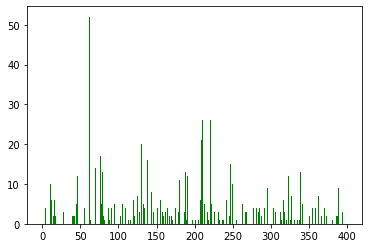

In [29]:
print(h_list.shape)
plt.bar(range(400),h_list[0,:] , color='g')

In [30]:
#test_h=histogram(test_data,codebooksize)
test_h=histogram_vq(test_des)
test_h=np.array(test_h)
test_h

array([[ 1, 37, 11, ...,  0,  0,  2],
       [11,  3,  0, ...,  0,  0,  0],
       [ 0, 20,  0, ...,  1,  0,  2],
       ...,
       [ 0,  0,  2, ...,  0,  0,  0],
       [ 0, 39,  9, ...,  0,  0,  0],
       [ 0,  9,  0, ...,  0,  3,  0]])

In [0]:
with open('histogram400_256_8.txt','wb') as f:
  pickle.dump(h_list,f)
with open('histogram_test400_256_8.txt','wb') as f:
  pickle.dump(test_h,f)
with open('label.txt','wb') as f:
  pickle.dump(label,f)
with open('test_name.txt','wb') as f:
  pickle.dump(test_name,f)

In [32]:
'''
with open('histogram.txt','rb') as f:
  h_list=pickle.load(f)
with open('histogram_test.txt','rb') as f:
  test_h=pickle.load(f)
with open('label.txt','rb') as f:
  label=pickle.load(f)
with open('test_name.txt','rb') as f:
  test_name=pickle.load(f)
'''

"\nwith open('histogram.txt','rb') as f:\n  h_list=pickle.load(f)\nwith open('histogram_test.txt','rb') as f:\n  test_h=pickle.load(f)\nwith open('label.txt','rb') as f:\n  label=pickle.load(f)\nwith open('test_name.txt','rb') as f:\n  test_name=pickle.load(f)\n"

In [0]:
X_train,X_val,y_train,y_val=train_test_split(h_list,label,test_size=0.1,random_state=42)

In [34]:
'''
X_train = xp.asarray(X_train)
X_val = xp.asarray(X_val)
y_train = xp.asarray(y_train)

#svm = SVM(kernel='linear', kernel_params={'sigma': 15}, classification_strategy='ovr', x=X_train, y=y_train, n_folds=3, use_optimal_lambda=True, display_plots=True)
svm = SVM(kernel='linear',classification_strategy='ovr', kernel_params={'C':1},x=X_train, y=y_train)

svm.fit(X_train, y_train)

X_val = xp.asarray(X_val)
val_fit=svm.predict(X_val)
print(type(xp.asnumpy(val_fit)))

test_h = xp.asarray(test_h)
result=svm.prdict(test_h)
result=xp.asnumpy(result)
'''


"\nX_train = xp.asarray(X_train)\nX_val = xp.asarray(X_val)\ny_train = xp.asarray(y_train)\n\n#svm = SVM(kernel='linear', kernel_params={'sigma': 15}, classification_strategy='ovr', x=X_train, y=y_train, n_folds=3, use_optimal_lambda=True, display_plots=True)\nsvm = SVM(kernel='linear',classification_strategy='ovr', kernel_params={'C':1},x=X_train, y=y_train)\n\nsvm.fit(X_train, y_train)\n\nX_val = xp.asarray(X_val)\nval_fit=svm.predict(X_val)\nprint(type(xp.asnumpy(val_fit)))\n\ntest_h = xp.asarray(test_h)\nresult=svm.prdict(test_h)\nresult=xp.asnumpy(result)\n"

In [35]:

from sklearn.model_selection import GridSearchCV

svm = SVC(kernel='linear')
param_grid = {'C':[1,2,3]}
grid = GridSearchCV(svm, param_grid, cv=5)

grid.fit(X_train,y_train)
#svm.fit(X_train,y_train)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='linear',
                           max_iter=-1, probability=False, random_state=None,
                           shrinking=True, tol=0.001, verbose=False),
             iid='warn', n_jobs=None, param_grid={'C': [1, 2, 3]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [36]:
val_fit=grid.predict(X_val)

result=grid.predict(test_h)
grid.best_params_


{'C': 1}

In [0]:
#val_fit=svm.predict(X_val)

In [38]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print(classification_report(xp.asnumpy(val_fit),y_val))

print(confusion_matrix(xp.asnumpy(val_fit),y_val))

              precision    recall  f1-score   support

           1       0.67      0.50      0.57         4
           2       0.80      1.00      0.89         4
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         2
           5       0.80      0.80      0.80         5
           6       0.80      1.00      0.89         4
           7       0.17      0.14      0.15         7
           8       0.00      0.00      0.00         5
           9       0.43      0.60      0.50         5
          10       0.20      0.25      0.22         4
          11       0.33      0.20      0.25         5
          12       0.50      0.29      0.36         7
          13       0.00      0.00      0.00         1
          14       1.00      0.50      0.67         4
          15       0.00      0.00      0.00         1
          16       0.50      0.67      0.57         3
          17       1.00      0.25      0.40         4
          18       1.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [0]:
result_=np.append(['Category'],result)
result_id=np.append(['Id'],test_name)


In [40]:
#df = pd.DataFrame(result_,columns=['id','Category'])
df = pd.DataFrame(result_,result_id,columns=[' '])
df.to_csv('results_.csv',index=True, header=False)
df

,
Id,Category
image_0001.jpg,38
image_0002.jpg,89
image_0003.jpg,92
image_0004.jpg,51
...,...
image_1688.jpg,27
image_1689.jpg,61
image_1690.jpg,29
image_1691.jpg,45


In [0]:
#! kaggle competitions submit -c 2019-ml-finalproject -f results_.csv -m "sanhee-1203"